<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization_2_Factor_Single_Month.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization by considering an investor who instead of simply optimizing the mean variance criterion, uses a linear boundary to decide what assets are to be included in the long-only portfolio. The investor will select the bundary to be of maximum margin while minimizing the portfolio variance. 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_{i} z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

In [2]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
drive.mount('/content/gdrive')
from math import sqrt
import math
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
%matplotlib inline


## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')

# import matplotlib
# import matplotlib.font_manager as fm
#
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# fm.fontManager.ttflist += fm.createFontList(['thsarabunnew-webfont.ttf'])
# matplotlib.rc('font', family='TH Sarabun New')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
try:
  e = gp.Env(empty=True)
  #e.setParam('OutputFlag', 0)
  gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
  e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
  e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
  e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
  e.start()
except: 
  !chmod 755 /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey
  !/content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/gurobi/grbgetkey 2d15bcec-464e-11ec-8a74-0242ac120003
  e = gp.Env(empty=True)
  #chmod 755 grbgetkey
  e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------

info  : grbgetkey version 9.1.2, build v9.1.1rc0-30-g8af970cb
info  : Contacting Gurobi license server...
info  : License file for license ID 726787 was successfully retrieved
info  : License expires at the end of the day on 2022-01-13
info  : Saving license file...

In which directory would you like to store the Gurobi license file?
[hit Enter to store it in /opt/gurobi]: 

info  : License 726787 written to file /opt/gurobi/gurobi.lic

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


In [4]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [5]:
wrds_svm.loc[:,'srcq':'prccq']

srcq       actq        ancq  ...  dvpspq       mkvaltq     prccq
MonthStart tic                                ...                                
2000-07-01 AAPL   5.0   5157.000    1775.000  ...   0.000    8663.94815   52.3750
           ABC    5.0   2266.194     136.586  ...   0.000    4161.78180   31.0000
           ABMD   5.0    114.037       4.832  ...   0.000    2249.28625   30.7500
           ABT    5.0   6898.036    8066.045  ...   0.190   21938.00085   44.5625
           ADBE   5.0    743.484     192.723  ...   0.025    3428.28785  112.5625
...               ...        ...         ...  ...     ...           ...       ...
2020-10-01 XOM    5.0  48693.000  309350.000  ...   0.870  145155.27320   34.3300
           XRAY   5.0   2579.600    6316.300  ...   0.100    9555.00500   43.7300
           XRX    5.0   6541.000    8811.000  ...   0.250    3865.81290   18.7700
           YUM    5.0   2030.000    4031.000  ...   0.470   27572.60000   91.3000
           ZBRA   5.0   1192.000    4053.000  ...   0.000   13455.61310  252.4600

[69784 rows x 38 columns]

In [61]:
#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)
#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")
#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Momentum"] # Y matrix in formulation 
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
Y_ = Y_.iloc[:,:]
#Y_ = Y_[['ROC1', 'INV1', 'PRO1'	, 'GRW1', 'LEV1', 'LIQ1']]
#Y_['momentum'] = mean
Y_ = Y_[['LEV1', 'GRW1']]
#Y_['momentum'] = mean
AssetLim = math.floor(N*0.8)
ret_constr = -1
soft_margin = 5000
dpi_setting = 150

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [62]:
print("Number of Assets: ", N)
print("Number of Balance Sheet Factors: ", len(wrds_svm.loc[:,'srcq':'prccq'].columns))
print("Number of periods for optimization: ", len(rets))

Number of Assets:  286
Number of Balance Sheet Factors:  38
Number of periods for optimization:  243


In [63]:
%run /content/gdrive/My\ Drive/Colab\ Notebooks/SVM\ MVO/PYFILES/svm_mvo.py

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET

--------------------------------------------
--------------------------------------------


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-01-13
Using license file /opt/gurobi/gurobi.lic


<Figure size 432x288 with 0 Axes>

### Simple Min Variance Portfolio 

In [64]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
             svm_choice = (False, False), print_var_frntr= False, cardinality = True) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 290 rows, 858 columns and 1716 nonzeros
Model fingerprint: 0xf73e973c
Model has 41041 quadratic objective terms
Model has 286 general constraints
Variable types: 572 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Presolve added 284 rows and 0 columns
Presolve removed 0 rows and 286 columns
Presolve time: 0.03s
Presolved: 574 rows, 572 columns, 1716 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)
Found heuristic solution: objective 0.0391937

Root relaxation: objective 6.860883e-04, 182 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 

0.15965795516967773

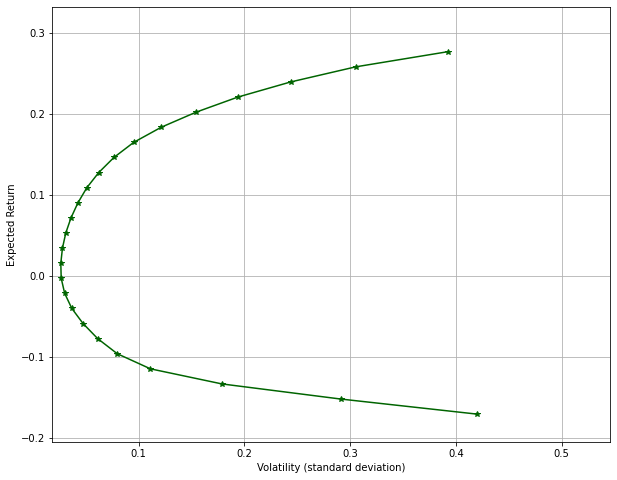

In [65]:
MVO.model.setParam('OutputFlag', 0)
MVO_frontier, ws, xis = MVO.get_frontier(); #ws and xi are not important here

### Mean Variance and SVM Joint Formulation

In [66]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
                 svm_choice = (True, False), print_var_frntr = False , indicator = False)
SVM_MVO.setModel()
SVM_MVO.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 862 rows, 861 columns and 4004 nonzeros
Model fingerprint: 0x2d574479
Model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 0.0904098
Presolve removed 112 rows and 396 columns
Presolve time: 0.04s
Presolved: 750 rows, 465 columns, 2882 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 289 continuous, 176 integer (176 binary)

Root relaxation: objective 6.860883e-04, 455 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node

16.832375288009644

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 862 rows, 861 columns and 4004 nonzeros
Model fingerprint: 0x3a038be5
Model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]

MIP start from previous solve produced solution with objective 0.178683 (0.10s)
Loaded MIP start from previous solve with objective 0.178683

Presolve removed 111 rows and 396 columns
Presolve time: 0.03s
Presolved: 751 rows, 465 columns, 3168 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 289 continuous, 176 integer (176 binary)

Root relaxation: objective 1.764509e-01, 423 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objecti

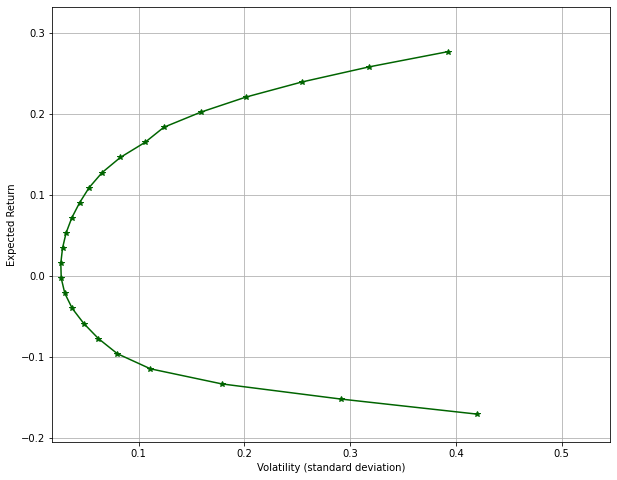

(array([[ 0.42006059,  0.29097598,  0.17876146,  0.1111245 ,  0.07985332,
          0.06195919,  0.0481021 ,  0.0371666 ,  0.03012374,  0.02674788,
          0.02633816,  0.02798809,  0.03132369,  0.03671741,  0.04409463,
          0.05309655,  0.06541774,  0.0826296 ,  0.10600482,  0.12380305,
          0.15874782,  0.20150011,  0.25448714,  0.31804847,  0.39207104],
        [-0.17088412, -0.15222962, -0.13357511, -0.11492061, -0.09626611,
         -0.07761161, -0.05895711, -0.04030261, -0.0216481 , -0.0029936 ,
          0.0156609 ,  0.0343154 ,  0.0529699 ,  0.07162441,  0.09027891,
          0.10893341,  0.12758791,  0.14624241,  0.16489692,  0.18355142,
          0.20220592,  0.22086042,  0.23951492,  0.25816943,  0.27682393]]),
 array([[ 4.66281992e-310,  0.00000000e+000,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  1.00000000e+001],
        [ 0.00000000e+000,              nan,  0.00000000e+000],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000],


In [67]:
SVM_MVO.get_frontier()

### There must be a model that is guaranteed to be feasible. Slack variables for the big M constraints will be introduced and penalized. These slack variables $\xi$ represent the degree of non-separability present among the assets

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 + \sum_{i=1}^N g(\xi_i)&\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R}, \quad \sum_i z_i \leq N \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon + \xi_i \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon - \xi_i \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N  \quad \xi \geq 0& \\
\end{align} 
$$

This model is always feasible. A common setting for g is $C \xi/N$ where $C$ is a hyperparameter. 

In [68]:
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, AssetLim,\
                      svm_choice = (True, True), print_var_frntr = True, indicator = False)
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 862 rows, 1147 columns and 4576 nonzeros
Model fingerprint: 0x0936fcbd
Model has 41043 quadratic objective terms
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]
Found heuristic solution: objective 1.000000e+13
Presolve removed 2 rows and 286 columns
Presolve time: 0.02s
Presolved: 860 rows, 861 columns, 4004 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)

Root relaxation: objective 6.861009e-04, 664 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/No

14.09810185432434

In [69]:
SVM_MVO_Slck.soft_penalty.getValue()

array([0.])

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 862 rows, 1147 columns and 4576 nonzeros
Model fingerprint: 0x63d842b9
Model has 41043 quadratic objective terms
Variable types: 861 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+02]
  Objective range  [2e+01, 2e+01]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 2e+02]

MIP start from previous solve produced solution with objective 0.178683 (0.09s)
Loaded MIP start from previous solve with objective 0.178683

Presolve removed 1 rows and 286 columns
Presolve time: 0.01s
Presolved: 861 rows, 861 columns, 4290 nonzeros
Presolved model has 41043 quadratic objective terms
Variable types: 575 continuous, 286 integer (286 binary)

Root relaxation: objective 1.764509e-01, 649 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objectiv

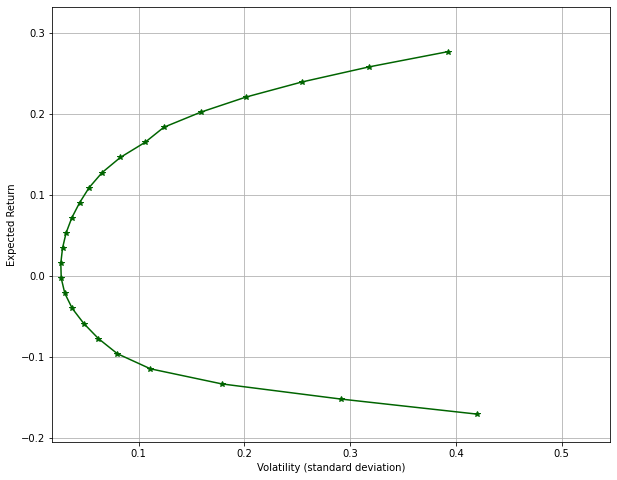

In [70]:
#SVM_MVO_Slck.model.setParam('OutputFlag', 0)
SVM_Slck_EF, ws, xis = SVM_MVO_Slck.get_frontier()

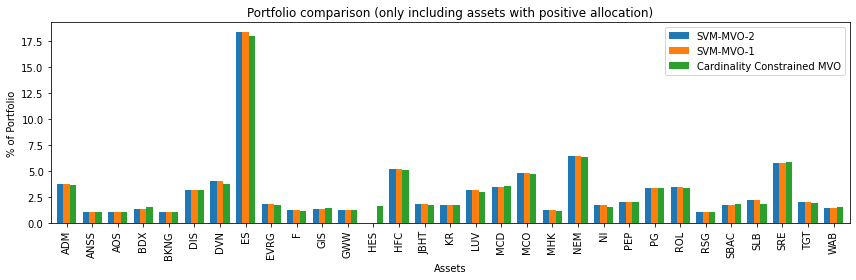

In [71]:
#portfolio comparison
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
(100*out[out.columns[(out > 0.01).any(axis = 0)]]).transpose()[:-2].plot.bar(title = 'Portfolio comparison (only including assets with positive allocation)',\
                                                                           xlabel = 'Assets', \
                                                                           ylabel = '% of Portfolio',\
                                                                           figsize = (12,4), width = 0.75);
plt.tight_layout()
plt.legend(['SVM-MVO-2','SVM-MVO-1','Cardinality Constrained MVO'])   #override                                                                       
plt.savefig(pth+"SVM MVO/Images/p1.png", dpi = dpi_setting)

For the portfolios up to the return point of 0.3, the solver finds linearly separable portfolios. After that point the solver defaults to including all the assets in the universe at the expense of increasing the cost of violating the linearly separable condition. 

The bias term acts as a radius that determines how far separating hyperplanes can be from the origin. If the bias was free to be any value then, it would be set to ensure z = 1 for all assets, which would imply w = 0, no constraint violations xi = 0 (since all assets are covered), and would therefore reduce the problem to the mean variance problem. 

The bias could be set to cover a percentile of assets feature vectors Y ? 

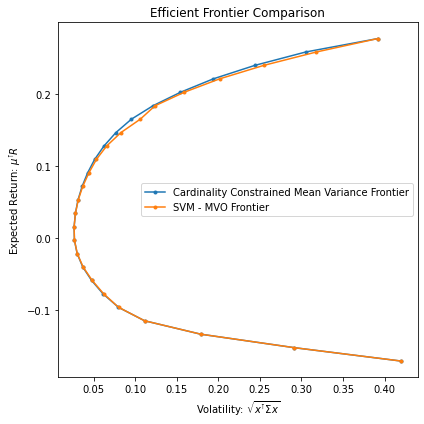

In [72]:
#Plot efficient frontiers for the SVM MVO an Vanilla MVO
plt.figure(figsize = (6,6))
plt.plot(MVO_frontier[0], MVO_frontier[1], ".-", label = "Cardinality Constrained Mean Variance Frontier");
plt.plot(SVM_Slck_EF[0], SVM_Slck_EF[1], ".-", label = "SVM - MVO Frontier");
plt.legend();
plt.ylabel('Expected Return: $\mu^{\intercal}R$')
plt.xlabel('Volatility: $\sqrt{x^{\intercal} \Sigma x}$')
plt.legend()
plt.title("Efficient Frontier Comparison");
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p2.png", dpi = dpi_setting)

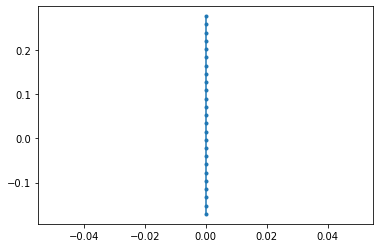

In [73]:
plt.plot(xis.sum(axis= 1), SVM_Slck_EF[1], ".-", label = "Slacks for each target");

In [74]:
from sympy.solvers import solve
from sympy import Symbol

xu, yu = tuple(np.ceil(Y_.max()))
xl, yl = tuple(np.floor(Y_.min()))
epsi = 10**(-1)

def getline(ws):
  x = Symbol('x')
  y = Symbol('y')
  epsi = 10**(-9)

  if abs(ws[0]) >= epsi and abs(ws[1]) >=epsi:
    try:
      xxu = float(solve(ws[0]*x  + ws[1]*yu + ws[2]  , x)[0].evalf())
      xxl = float(solve(ws[0]*x  + ws[1]*yl + ws[2]  , x)[0].evalf())
      yyl = float(solve(ws[0]*xl  + ws[1]*y + ws[2]  , y)[0].evalf())
      yyu = float(solve(ws[0]*xu  + ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      xxu = (-1)*(ws[1]*yu + ws[2])/ws[0]
      xxl = (-1)*(ws[1]*yl + ws[2])/ws[0]
      yyl = (-1)*(ws[0]*xl + ws[2])/ws[1]
      yyu = (-1)*(ws[0]*xu + ws[2])/ws[1]

    candidates = [(xxu, yu), (xxl, yl), (xl, yyl), (xu, yyu) ]
    tuples = []
    for tup in candidates:
      if tup[0] <= xu and tup[0] >= xl and tup[1] <= yu and tup[1] >= yl:
        tuples.append(tup)

  elif abs(ws[0]) >= epsi and abs(ws[1]) < epsi: #y coeff is small
    try:
      xx = float(solve(ws[0]*x + ws[2]  , x)[0].evalf())
    except:
      xx = (-1)*ws[2]/ws[0]
    

    if xx <= xu and xx >= xl:
      tuples = [(xx, yl), (xx, yu)]
    elif xx > xu:
      tuples = [(xu, yl), (xu, yu)]
    elif xx < xl:
      tuples = [(xl, yl), (xl, yu)]

  elif abs(ws[0]) < epsi and abs(ws[1]) >= epsi: #x coeff is small
    try:
      yy = float(solve(ws[1]*y + ws[2]  , y)[0].evalf())
    except:
      yy =  (-1)*ws[2]/ws[1]
    
    if yy <= yu and yy >= yl:
      tuples = [(xu, yy), (xl, yy)]
    elif yy > yu:
      tuples = [(xu, yu), (xl, yu)]
    elif yy < yl:
      tuples = [(xl, yl), (xl, yl)]

  else: 
    print("No Valid Separating Hyperplanes")
    return None 
  return tuples

In [95]:
supports  = pd.DataFrame(ws)
supports['ret'] = SVM_Slck_EF[1,:]
supports.drop([0, len(supports)-1],inplace = True)
bigM = 10**(2)
supports_uniq = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).first()
supports_uniq['last_ret'] = supports.groupby([np.ceil(supports[0] * bigM) /bigM,  \
                  np.ceil(supports[1] * bigM) / bigM, \
                  np.ceil(supports[2] * bigM) / bigM]).last()['ret']
supports_uniq['desc'] = "Return Target : " +  np.round(supports_uniq['ret'], decimals = 2).astype(str) \
                      +  " to " + np.round(supports_uniq['last_ret'], decimals = 2).astype(str) 

for idx in supports_uniq.index:
  if supports_uniq.loc[idx,'last_ret'] == supports_uniq.loc[idx,'ret']:
    supports_uniq.loc[idx, 'desc'] = "Return Target : " + \
                                      np.round(supports_uniq.loc[idx,'ret'], decimals = 2).astype(str)
supports_uniq

,,,0,1,2,ret,last_ret,desc
0,1,2,,,,,,
0.04,0.06,0.01,0.030272,0.059563,0.006203,-0.152230,0.164897,Return Target : -0.15 to 0.16
0.09,0.01,0.02,0.085694,0.004979,0.012835,0.183551,0.183551,Return Target : 0.18
0.10,0.02,0.02,0.097784,0.010454,0.013264,0.202206,0.258169,Return Target : 0.2 to 0.26


In [96]:
supports

,0,1,2,ret
1,0.030272,0.059563,0.006203,-0.152230
2,0.030272,0.059563,0.006203,-0.133575
3,0.030272,0.059563,0.006203,-0.114921
4,0.030272,0.059563,0.006203,-0.096266
5,0.030272,0.059563,0.006203,-0.077612
6,0.030272,0.059563,0.006203,-0.058957
7,0.030272,0.059563,0.006203,-0.040303
8,0.030272,0.059563,0.006203,-0.021648
9,0.030272,0.059563,0.006203,-0.002994
10,0.030272,0.059563,0.006203,0.015661


0
1
2


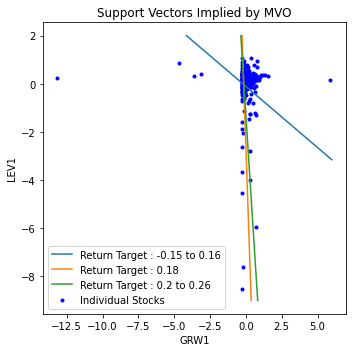

In [97]:
fig, ax = plt.subplots(figsize=(5,5))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=Y_.iloc[:,0], y=Y_.iloc[:,1],
           color='Blue', label='Individual Stocks', marker = '.')
#for stock in Y_.index:
  #ax.annotate(stock, (Y_.loc[stock][0], Y_.loc[stock[1]))
for i in range(supports_uniq[[0,1,2]].values.shape[0]):
  print(i)
  line = getline(supports_uniq[[0,1,2]].values[i,:])
  if line is not None:
    ax.plot(*zip(*line), label = supports_uniq.iloc[i]['desc'])
plt.legend();
plt.ylabel(Y_.columns[0])
plt.xlabel(Y_.columns[1])
plt.title('Support Vectors Implied by MVO')
plt.tight_layout()                                                                           
plt.savefig(pth+"SVM MVO/Images/p3.png",dpi = dpi_setting)